In [76]:
import pandas as pd
df = pd.read_csv('CLEANED_FMCG_2022_2024.csv')
df.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


you want us to drill down into Aug 2023 specifically (e.g., top SKUs, regions, channels for that peak month) to uncover why sales exploded? That could directly connect your EDA with Step 2: Inventory Optimization tomorrow.

Deep Dive Plan – August 2023

Filter dataset → keep only rows from Aug 2023.

In [77]:
df['date'] = pd.to_datetime(df['date'])

In [78]:
aug_2023 = df[(df['date'] >= '2023-8-1') & (df['date'] <= '2023-8-31')]

Top SKUs → find which products drove sales.

In [79]:
aug_2023.groupby('sku')['units_sold'].sum().sort_values(ascending=False).reset_index().head(10)


,sku,units_sold
0,SN-030,7095
1,SN-028,7070
2,MI-008,6262
3,MI-002,6234
4,SN-019,6230
5,YO-018,6227
6,YO-024,6170
7,MI-011,5834
8,SN-013,5565
9,SN-010,5453


 dominated.

In [80]:
aug_2023.groupby('category')['units_sold'].sum().sort_values(ascending=False).head()

category
Yogurt       55451
SnackBar     36682
Milk         36678
ReadyMeal    20844
Juice         4607
Name: units_sold, dtype: int64

Channels → check whether Retail, Discount, or Online channels contributed most.

In [81]:
aug_2023.groupby('channel')['units_sold'].sum().sort_values(ascending=False)

channel
Discount      52192
E-commerce    51407
Retail        50663
Name: units_sold, dtype: int64

Regions → see which part of the country drove the spike.

In [82]:
aug_2023.groupby('region')['units_sold'].sum(
).sort_values(ascending=False).head()

region
PL-Central    51636
PL-North      51390
PL-South      51236
Name: units_sold, dtype: int64

🧠 Business Angle

Once we run those, we can answer:

Was the peak driven by a few SKUs (blockbuster products)?

Did a brand/category do something special (promo, price cut)?

Was it regional (e.g., North booming)?

Or did every channel rise together (a company-wide push)?

Day 2 – Inventory Optimization

Goal: Identify fast vs. slow-moving products so the company can:

Avoid overstocking slow movers

Avoid running out of fast movers

Step 2 Plan

Define fast vs. slow movers

Usually based on sales volume (e.g., top 20% SKUs = fast movers, bottom 20% = slow movers).

Could also factor in stock availability vs. units_sold.

Aggregate sales per SKU

sku_sales = df.groupby('sku')['units_sold'].sum().sort_values(ascending=False)


Rank SKUs

Create a ranking or percentiles (e.g., top 10% = fastest).

This helps visualize the distribution.

Business insight

Which SKUs are blockbusters (always selling)?

Which are laggards (sitting in inventory, tying up cash)?

🔹 Why group by sku + pack_type?

Each SKU represents a unique product code (e.g. SN-018).

But in your dataset, the same SKU can appear with different pack types (Single, Multi, Carton).

That means SKU alone isn’t unique — because SN-018 Single ≠ SN-018 Multi ≠ SN-018 Carton.

If we only group by sku, we mix up all pack sizes together, and we won’t know which pack type is fast or slow moving.

🔹 Example

Imagine your raw sales look like this:

sku	category	pack_type	units_sold
SN-018	SnackBar	Single	2,000
SN-018	SnackBar	Multi	5,000
SN-018	SnackBar	Carton	10,000
SN-030	SnackBar	Single	3,500

If we group only by SKU:
👉 SN-018 = 17,000 units.
But we lose track of which pack type sold better.

If we group by SKU + Pack type:
👉 SN-018 Single = 2,000
👉 SN-018 Multi = 5,000
👉 SN-018 Carton = 10,000

That way, we can see which pack type is moving faster.
For example, maybe Cartons are fast movers but Singles are slow movers.

🔹 Why this matters for inventory optimization

If Cartons are selling fast, the warehouse should stock more Cartons.

If Singles are slow movers, the company may reduce production or run promotions to clear them before expiry.

So grouping by sku + pack_type is not mixing up data — it’s actually separating them properly so you can analyze each variant fairly.

✅ If you agree with this logic, we can proceed with grouping by sku + pack_type.

In [83]:
sku_pack_sales_grouped = (df.groupby(
    ['sku', 'category', 'pack_type'], as_index=False)['units_sold'].sum())
print(sku_pack_sales_grouped)#.head(10)

       sku category  pack_type  units_sold
0   JU-021    Juice     Carton       41949
1   JU-021    Juice  Multipack       41437
2   JU-021    Juice     Single       40963
3   MI-002     Milk     Carton       32617
4   MI-002     Milk  Multipack       30486
..     ...      ...        ...         ...
85  YO-024   Yogurt  Multipack       36574
86  YO-024   Yogurt     Single       36060
87  YO-029   Yogurt     Carton       58681
88  YO-029   Yogurt  Multipack       60588
89  YO-029   Yogurt     Single       58529

[90 rows x 4 columns]


2️⃣ Ranking on units_sold

In [85]:
sku_pack_sales_grouped['rank'] = sku_pack_sales_grouped['units_sold'].rank(ascending=False, method='dense')

 Percentile (relative standing from 0 → 1)

In [ ]:
sku_pack_sales_grouped['percentile'] = sku_pack_sales_grouped['units_sold'].rank(pct=True, ascending=False)
print(sku_pack_sales_grouped.head(60))

       sku   category  pack_type  units_sold  rank  percentile  mover_type
0   JU-021      Juice     Carton       41949  43.0    0.477778    0.533333
1   JU-021      Juice  Multipack       41437  45.0    0.500000    0.511111
2   JU-021      Juice     Single       40963  48.0    0.533333    0.477778
3   MI-002       Milk     Carton       32617  79.0    0.877778    0.133333
4   MI-002       Milk  Multipack       30486  84.0    0.933333    0.077778
5   MI-002       Milk     Single       32431  81.0    0.900000    0.111111
6   MI-006       Milk     Carton       43706  40.0    0.444444    0.566667
7   MI-006       Milk  Multipack       44781  36.0    0.400000    0.611111
8   MI-006       Milk     Single       44136  38.0    0.422222    0.588889
9   MI-008       Milk     Carton       28754  86.0    0.955556    0.055556
10  MI-008       Milk  Multipack       27079  89.0    0.988889    0.022222
11  MI-008       Milk     Single       27055  90.0    1.000000    0.011111
12  MI-011       Milk    

4. Classify into buckets (fast, medium, slow)

In [98]:
def classify(x):
    if x >= 0.8:
        return 'Fast Mover'
    elif x <= 0.2:
        return 'Slow Mover'
    else:
        return 'Medium Mover'


sku_pack_sales_grouped['mover_type'] = sku_pack_sales_grouped['percentile'].apply(classify)

In [99]:
print(sku_pack_sales_grouped.head(60))

       sku   category  pack_type  units_sold  rank  percentile    mover_type
0   JU-021      Juice     Carton       41949  43.0    0.477778  Medium Mover
1   JU-021      Juice  Multipack       41437  45.0    0.500000  Medium Mover
2   JU-021      Juice     Single       40963  48.0    0.533333  Medium Mover
3   MI-002       Milk     Carton       32617  79.0    0.877778    Fast Mover
4   MI-002       Milk  Multipack       30486  84.0    0.933333    Fast Mover
5   MI-002       Milk     Single       32431  81.0    0.900000    Fast Mover
6   MI-006       Milk     Carton       43706  40.0    0.444444  Medium Mover
7   MI-006       Milk  Multipack       44781  36.0    0.400000  Medium Mover
8   MI-006       Milk     Single       44136  38.0    0.422222  Medium Mover
9   MI-008       Milk     Carton       28754  86.0    0.955556    Fast Mover
10  MI-008       Milk  Multipack       27079  89.0    0.988889    Fast Mover
11  MI-008       Milk     Single       27055  90.0    1.000000    Fast Mover

Pivot for multiple bar chart (sku+category as index, pack_type as bars)

In [100]:
import matplotlib.pyplot as plt

#set pivottable first
pivot = sku_pack_sales_grouped.pivot_table(
    index=['category', 'sku'],
    columns='pack_type',
    values='units_sold'
)

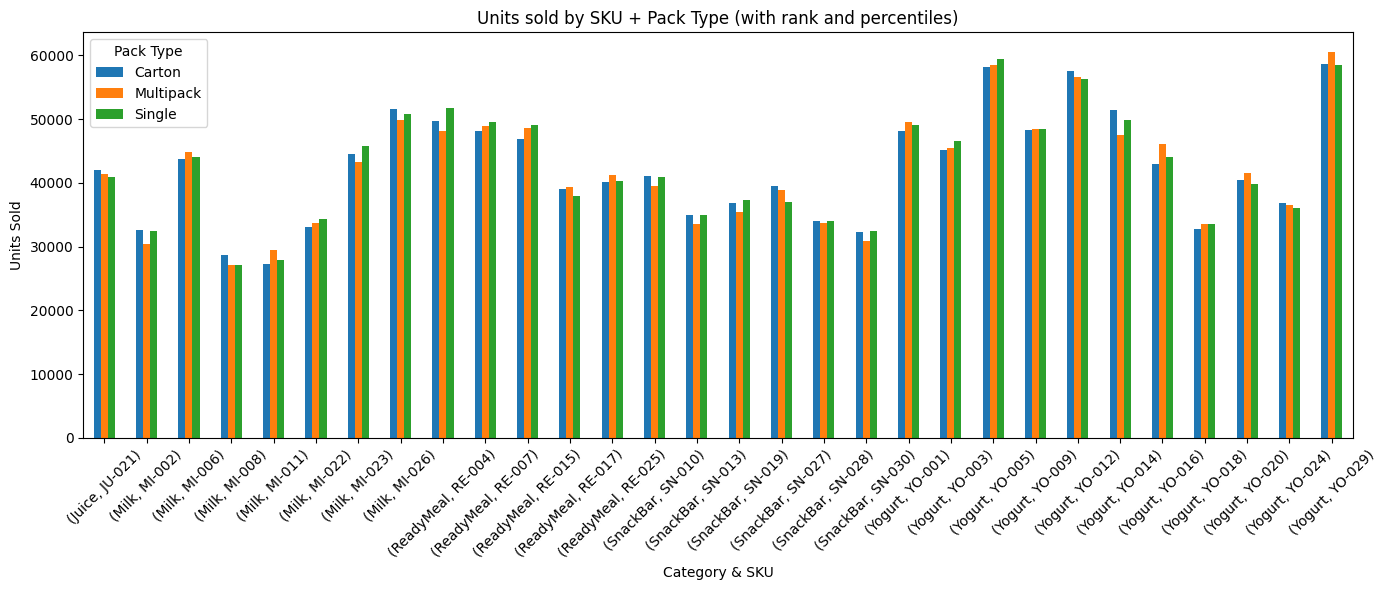

In [102]:
#set multiple barchart
pivot.plot(kind='bar', figsize=(14,6))
plt.title('Units sold by SKU + Pack Type (with rank and percentiles)')
plt.ylabel('Units Sold')
plt.xlabel('Category & SKU')
plt.xticks(rotation=45)
plt.legend(title='Pack Type')
plt.tight_layout()
plt.show()